## Importación de librerías

In [59]:
import pandas as pd
import json
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from collections import defaultdict
import random
import joblib
import seaborn as sns

## Configuración de variables globales

In [60]:
with open('setup.json', 'r') as f:
    SETUP_JSON = json.load(f)
FINAL_DATASET = SETUP_JSON['final_dataset']
LEARNING_RATE = SETUP_JSON['learning_rate']
EPOCHS = SETUP_JSON['epochs']

## Cargar el dataset

In [61]:
df = pd.read_parquet(FINAL_DATASET) # Leer dataset final
df.shape

(8247888, 34)

In [62]:
df.head()

,Timestamp,Dst Port,Protocol,Tot Fwd Pkts,TotLen Fwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Mean,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,...,Fwd Seg Size Avg,Bwd Seg Size Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Init Fwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Label,Label Code,Sequence ID
0,0.866025,0,0,3.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,3.0,0.0,-1.0,0.0,0.0,Benign,0,1
1,0.866025,0,0,3.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,3.0,0.0,-1.0,0.0,0.0,Benign,0,1
2,0.866025,0,0,3.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,3.0,0.0,-1.0,0.0,0.0,Benign,0,1
3,0.866025,22,6,15.0,1239.0,744.0,82.600000,976.0,0.0,227.300000,...,82.600000,227.300000,15.0,1239.0,65535.0,6.0,32.0,Benign,0,1
4,0.866025,22,6,14.0,1143.0,744.0,81.642857,976.0,0.0,200.818182,...,81.642857,200.818182,14.0,1143.0,5808.0,6.0,32.0,Benign,0,1


## Invertir el mapeo de etiquetas

In [63]:
# Mapeo de etiquetas
labels = df['Label'].unique()
labels_codes = df['Label Code'].unique()
label_mapping = {int(label_code): label for label_code, label in zip(labels_codes, labels)}
label_mapping

{0: 'Benign',
 1: 'FTP-BruteForce',
 2: 'SSH-Bruteforce',
 3: 'DoS attacks-GoldenEye',
 4: 'DoS attacks-Slowloris',
 5: 'DoS attacks-SlowHTTPTest',
 6: 'DoS attacks-Hulk',
 7: 'DDOS attack-LOIC-UDP',
 8: 'DDOS attack-HOIC',
 9: 'Brute Force -Web',
 10: 'Brute Force -XSS',
 11: 'SQL Injection',
 12: 'Infilteration',
 13: 'Bot'}

## Extracción de secuencias de paquetes

In [64]:
# Obtener una lista de DataFrames de secuencias
sequences = [group_df for _, group_df in df.groupby('Sequence ID')] # Modificado para mantener 'Sequence ID'
print(f"Total de secuencias: {len(sequences)}")

Total de secuencias: 939866


In [65]:
sequences[0].head()

,Timestamp,Dst Port,Protocol,Tot Fwd Pkts,TotLen Fwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Mean,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,...,Fwd Seg Size Avg,Bwd Seg Size Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Init Fwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Label,Label Code,Sequence ID
0,0.866025,0,0,3.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,3.0,0.0,-1.0,0.0,0.0,Benign,0,1
1,0.866025,0,0,3.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,3.0,0.0,-1.0,0.0,0.0,Benign,0,1
2,0.866025,0,0,3.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,3.0,0.0,-1.0,0.0,0.0,Benign,0,1
3,0.866025,22,6,15.0,1239.0,744.0,82.600000,976.0,0.0,227.300000,...,82.600000,227.300000,15.0,1239.0,65535.0,6.0,32.0,Benign,0,1
4,0.866025,22,6,14.0,1143.0,744.0,81.642857,976.0,0.0,200.818182,...,81.642857,200.818182,14.0,1143.0,5808.0,6.0,32.0,Benign,0,1


## Balanceo de clases

Vemos que las clases están desbalanceadas

In [66]:
sequences_df = pd.DataFrame({
    'Clase': [seq['Label'].iloc[0] for seq in sequences]
})
sequences_df['Clase'].value_counts()

Clase
Benign                      458797
DoS attacks-Hulk            246538
DDOS attack-HOIC            172030
Infilteration                29269
SSH-Bruteforce                8342
FTP-BruteForce                7557
Bot                           6737
DoS attacks-GoldenEye         5026
DoS attacks-Slowloris         4668
DDOS attack-LOIC-UDP           635
Brute Force -XSS               109
Brute Force -Web                73
DoS attacks-SlowHTTPTest        53
SQL Injection                   32
Name: count, dtype: int64

Establecer la mediana como número máximo de secuencias por cada clase

In [67]:
max_sequences = int(sequences_df['Clase'].value_counts().median())
print(f"Número máximo de secuencias: {max_sequences}")

Número máximo de secuencias: 5881


Agrupar secuencias por clase

In [68]:
# Agrupar secuencias por ID de secuencia (en lugar de clase)
sequences_by_id = defaultdict(list)
for seq_df in sequences:
    sequence_id_val = seq_df['Sequence ID'].iloc[0]  # Obtener el ID de la secuencia
    sequences_by_id[sequence_id_val].append(seq_df)  # Agrupar por ID de secuencia

Aplicar submuestreo aleatorio para las clases con más secuencias

In [69]:
balanced_sequences_list = []
# Recorrer cada ID de secuencia y su lista de DataFrames (que contendrá un solo DataFrame)
for id_val, sequence_list in sequences_by_id.items(): # Modificado desde sequences_by_class.values()
    # La lógica de submuestreo original se basaba en tener múltiples secuencias (flujos) por CLASE.
    # Ahora, cada grupo (por ID de secuencia) tiene solo una secuencia (un DataFrame).
    # len(sequence_list) será 1.
    # La condición `if len(sequence_list) > max_sequences:` (es decir, `if 1 > max_sequences`)
    # significa que el submuestreo original no se aplicará a menos que max_sequences sea 0.
    # Esto efectivamente elimina el balanceo de clases si max_sequences >= 1.
    if len(sequence_list) > max_sequences:
        sequence_list = random.sample(sequence_list, max_sequences)
    balanced_sequences_list.extend(sequence_list)

sequences = balanced_sequences_list # Actualizar la variable sequences

# Mostrar cuántas secuencias se obtuvieron en total tras el cambio en la agrupación
print(f"Total de secuencias: {len(sequences)}")

Total de secuencias: 939866


Vemos que ahora las clases están más balanceadas

In [70]:
sequence_df = pd.DataFrame({
    'Clase': [seq['Label'].iloc[0] for seq in sequences],
    'Longitud': [len(seq) for seq in sequences]
})
sequence_df['Clase'].value_counts()

Clase
Benign                      458797
DoS attacks-Hulk            246538
DDOS attack-HOIC            172030
Infilteration                29269
SSH-Bruteforce                8342
FTP-BruteForce                7557
Bot                           6737
DoS attacks-GoldenEye         5026
DoS attacks-Slowloris         4668
DDOS attack-LOIC-UDP           635
Brute Force -XSS               109
Brute Force -Web                73
DoS attacks-SlowHTTPTest        53
SQL Injection                   32
Name: count, dtype: int64

## Separación de datos

Definir la longitud promedio como longitud fija para cada secuencia

In [71]:
# Definir la longitud media como longitud fija de cada secuencia
sequence_length = int(np.mean(sequence_df['Longitud']))
print(f"Longitud promedio de secuencia: {sequence_length}")

Longitud promedio de secuencia: 8


Forzamos la longitud obtenida para secuencia y separamos las secuencias en X e y

In [72]:
# Definir las columnas de características y el número de características
# Esto se hace aquí porque 'sequences[0]' ahora contiene 'Sequence ID'
# Primero, eliminamos explícitamente 'Sequence ID' de cada DataFrame en la lista 'sequences'
# ya que no se utilizará como característica para el modelo.
sequences_for_features = []
if sequences: # Asegurarse de que la lista 'sequences' no esté vacía
    for seq_df_item in sequences:
        sequences_for_features.append(seq_df_item.drop(columns=['Sequence ID'], errors='ignore'))

# Definir las columnas de características y el número de características.
# 'Sequence ID' ya ha sido eliminada de los DataFrames en 'sequences_for_features'.
if sequences_for_features:
    feature_columns = [col for col in sequences_for_features[0].columns if col not in ['Label', 'Label Code']]
else:
    feature_columns = [] # Manejar el caso de lista vacía, aunque no debería ocurrir.
num_features = len(feature_columns)
X_list = []
y_list = []

for seq_df in sequences_for_features: # Iterar sobre las secuencias ya procesadas
    sequence_X_data = seq_df[feature_columns].to_numpy() # Obtener las características como numpy array
    sequence_Y_data = seq_df['Label Code'].iloc[0] # Obtener el código de la etiqueta

    # Ajustar longitud fija para cada secuencia
    current_len = sequence_X_data.shape[0]
    if current_len < sequence_length:
        # Rellenar con ceros
        pad_width_rows = sequence_length - current_len
        sequence_X_padded = np.pad(sequence_X_data, ((0, pad_width_rows), (0, 0)), mode='constant')

    else:
        # Recortar
        sequence_X_padded = sequence_X_data[:sequence_length, :]
        
    X_list.append(sequence_X_padded)
    y_list.append(sequence_Y_data)


X = np.array(X_list)
y = np.array(y_list)
X.shape, y.shape

((939866, 8, 31), (939866,))

Escalamiento de características

In [73]:
# num_features ahora se define en la celda anterior a partir de feature_columns
scaler = StandardScaler()
X_reshaped = X.reshape(-1, num_features) # num_features viene de la celda anterior
X_scaled_reshaped = scaler.fit_transform(X_reshaped)
X = X_scaled_reshaped.reshape(len(y), sequence_length, num_features)

In [74]:
X[0][0]

array([ 4.27309706, -0.33489362, -0.50585653, -0.01310353, -0.0160788 ,
       -0.33792127, -0.34425248, -0.30775445, -0.09505597, -0.33028588,
       -0.06224859, -0.0459007 , -0.05463007, -0.0273703 , -0.01593586,
       -0.06104951, -0.05810892, -0.34246668, -0.35265004, -0.34741537,
       -0.25552332, -0.43275688, -0.08352191, -0.35553421, -0.34425248,
       -0.33028588, -0.01310353, -0.0160788 , -0.32107117, -0.01439671,
       -0.52087017])

## Separar secuencias en entrenamiento, validación y prueba

Separación de datos

In [75]:
# Separar en conjuntos de entrenamiento, validación y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)

print(f"Conjunto de entrenamiento: {X_train.shape}, {y_train.shape}")
print(f"Conjunto de validación: {X_val.shape}, {y_val.shape}")
print(f"Conjunto de prueba: {X_test.shape}, {y_test.shape}")

Conjunto de entrenamiento: (601513, 8, 31), (601513,)
Conjunto de validación: (150379, 8, 31), (150379,)
Conjunto de prueba: (187974, 8, 31), (187974,)


Convertir a formato adecuado de entrada para el modelo

In [76]:
# Convertir a tensores
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

## Inicialización del modelo

In [77]:
# Modelo LSTM
class NetFlowLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.classifier = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)         # h_n shape: (1, batch, hidden)
        return self.classifier(h_n[-1])    # usar último estado oculto

model = NetFlowLSTM(input_dim=num_features, hidden_dim=32, output_dim=len(labels))

## Entrenamiento

Configuración del entrenamiento

In [78]:
"""# Configurar entrenamiento
weights = torch.tensor([0.3] + [1.0] * (len(labels) - 1))  # clase 0 = benigno, clase 1 = ataque"""
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [79]:
# Función de predicción
def predict(model, X_tensor):
    model.eval()
    with torch.no_grad():
        outputs = model(X_tensor)
    return outputs

In [80]:
# Función de evaluación
def evaluate_model(pred, y_tensor):
    loss = criterion(pred, y_tensor)
    pred = torch.argmax(pred, dim=1)
    acc = (pred == y_tensor).float().mean()
    return loss.item(), acc.item()

Entrenamiento del modelo

In [81]:
val_losses, val_accuracies = [], []

for epoch in range(EPOCHS):
    # Entrenamiento
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    val_pred = predict(model, X_val_tensor) # Predicción
    val_loss, val_acc = evaluate_model(val_pred, y_val_tensor) # Evaluación

    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1:02d} | Loss: {loss.item():.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}")

Epoch 10 | Loss: 1.3410 | Val Loss: 1.3427 | Val Acc: 0.48
Epoch 20 | Loss: 1.1641 | Val Loss: 1.1144 | Val Acc: 0.50
Epoch 30 | Loss: 0.6638 | Val Loss: 0.6286 | Val Acc: 0.91
Epoch 40 | Loss: 0.3923 | Val Loss: 0.3736 | Val Acc: 0.93
Epoch 50 | Loss: 0.2606 | Val Loss: 0.2517 | Val Acc: 0.94
Epoch 60 | Loss: 0.1884 | Val Loss: 0.1843 | Val Acc: 0.95
Epoch 70 | Loss: 0.1469 | Val Loss: 0.1445 | Val Acc: 0.96
Epoch 80 | Loss: 0.1192 | Val Loss: 0.1176 | Val Acc: 0.97
Epoch 90 | Loss: 0.0988 | Val Loss: 0.0981 | Val Acc: 0.97
Epoch 100 | Loss: 0.0837 | Val Loss: 0.0837 | Val Acc: 0.97


## Gráfica del entrenamiento

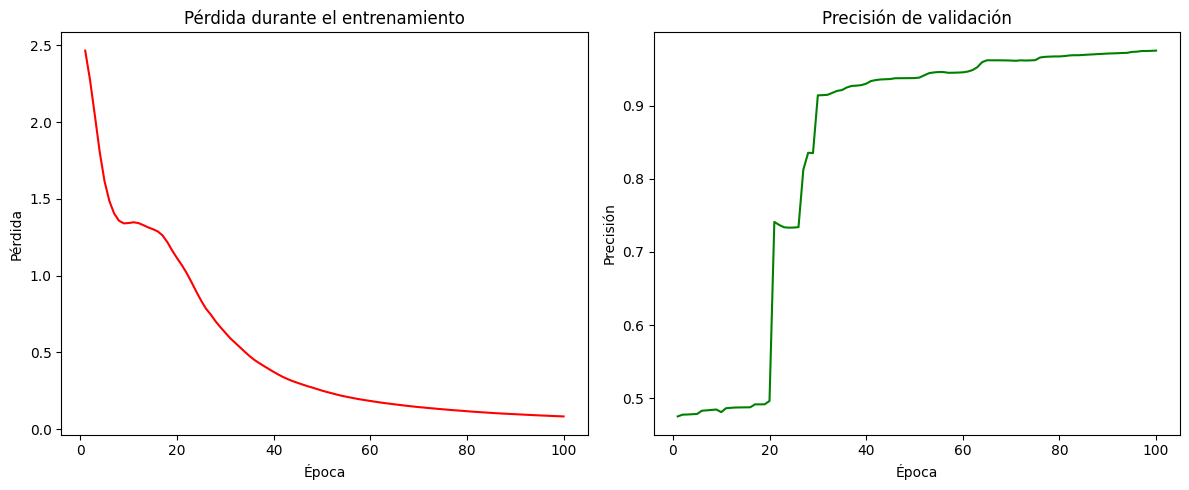

In [82]:
epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(12, 5))

# Pérdidas
plt.subplot(1, 2, 1)
plt.plot(epochs_range, val_losses, color='red')
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.title("Pérdida durante el entrenamiento")

# Precisión
plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_accuracies, color='green')
plt.xlabel("Época")
plt.ylabel("Precisión")
plt.title("Precisión de validación")

plt.tight_layout()
plt.show()

## Evaluación

Evaluación en el conjunto de test

In [83]:
test_pred = predict(model, X_test_tensor) # Predicción
test_loss, test_acc = evaluate_model(test_pred, y_test_tensor) # Evaluación

print(f"\n🔍 Evaluación final en test:")
print(f"Pérdida en test: {test_loss:.4f}")
print(f"Precisión en test: {test_acc:.2f}")


🔍 Evaluación final en test:
Pérdida en test: 0.0836
Precisión en test: 0.98


Matriz de confusión de la predicción obtenida

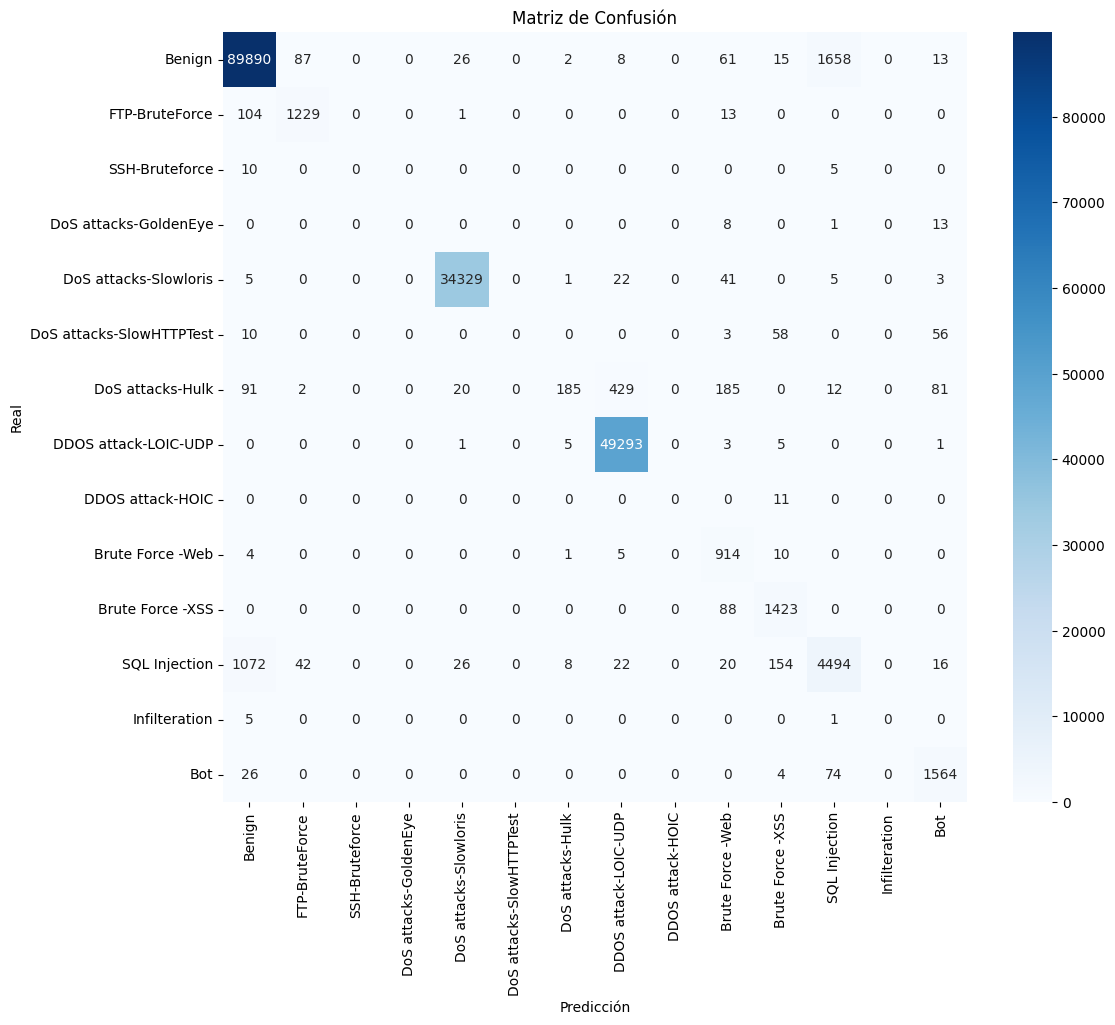

In [84]:
pred = torch.argmax(test_pred, dim=1).numpy()
pred_names = np.array([label_mapping[y] for y in pred])
y_test_names = np.array([label_mapping[y] for y in y_test])

# Calcular matriz de confusión
cm = confusion_matrix(y_test_names, pred_names)

# Visualizar
plt.figure(figsize=(12, 10))
sns.heatmap(
	cm,
	annot=True,
	fmt='d',
	cmap='Blues',
	xticklabels=labels,
	yticklabels=labels
)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

## Evaluación por clase

Evaluación por cada clase en el conjunto de test

In [85]:
# Diccionario para almacenar los datos de test por clase
test_data_by_class = {}

# Almacenar los datos de test por clase
for class_label in torch.unique(y_test_tensor):
    mask = y_test_tensor == class_label
    class_name = label_mapping[class_label.item()]
    test_data_by_class[class_name] = {
        'X': X_test_tensor[mask],
        'y': y_test_tensor[mask]
    }

for cls, data in test_data_by_class.items():
    X_cls, y_cls = data['X'], data['y']
    cls_pred = predict(model, X_cls) # Predicción
    cls_loss, cls_acc = evaluate_model(cls_pred, y_cls) # Evaluación
    print(f"Clase: {cls}, Pérdida: {cls_loss:.4f}, Precisión: {cls_acc:.2f}")

Clase: Benign, Pérdida: 0.0467, Precisión: 0.98
Clase: FTP-BruteForce, Pérdida: 0.3319, Precisión: 0.94
Clase: SSH-Bruteforce, Pérdida: 0.4976, Precisión: 0.94
Clase: DoS attacks-GoldenEye, Pérdida: 1.8336, Precisión: 0.18
Clase: DoS attacks-Slowloris, Pérdida: 0.8797, Precisión: 0.98
Clase: DoS attacks-SlowHTTPTest, Pérdida: 2.5654, Precisión: 0.00
Clase: DoS attacks-Hulk, Pérdida: 0.0107, Precisión: 1.00
Clase: DDOS attack-LOIC-UDP, Pérdida: 4.1363, Precisión: 0.00
Clase: DDOS attack-HOIC, Pérdida: 0.0233, Precisión: 1.00
Clase: Brute Force -Web, Pérdida: 7.6523, Precisión: 0.00
Clase: Brute Force -XSS, Pérdida: 5.8662, Precisión: 0.00
Clase: SQL Injection, Pérdida: 6.4830, Precisión: 0.00
Clase: Infilteration, Pérdida: 0.7793, Precisión: 0.77
Clase: Bot, Pérdida: 0.5240, Precisión: 0.91


## Despliegue

In [97]:
# --- Guardar el Diccionario de Estado del Modelo ---
model_save_path = 'flask-csv-api\\netflow_lstm_model_state_dict.pth'
torch.save(model.state_dict(), model_save_path)

# --- Guardar el Escalador ---
scaler_save_path = 'flask-csv-api\\scaler.joblib'
joblib.dump(scaler, scaler_save_path)

# --- Guardar el Mapeo de Etiquetas ---
label_mapping_save_path = 'flask-csv-api\\label_mapping.json'
with open(label_mapping_save_path, 'w') as f:
    json.dump(label_mapping, f, indent=4)

# --- Guardar Parámetros del Modelo (sequence_length, num_features, feature_columns) ---
feature_columns = [col for col in sequences[0].columns if col not in ['Label', 'Label Code', 'Sequence ID']]
sequence_length = X_train_tensor[0].shape[0]
print(feature_columns)
model_params = {
    'sequence_length': sequence_length,
    'num_features': num_features,
    'hidden_dim': model.lstm.hidden_size, # Obtener hidden_dim de la instancia del modelo
    'output_dim': model.classifier.out_features, # Obtener output_dim de la instancia del modelo
    'feature_columns': feature_columns # Guardar el orden de las columnas de características
}

# --- Exportar los Parámetros del Modelo ---
model_params_save_path = 'flask-csv-api\\model_params.json'
with open(model_params_save_path, 'w') as f:
    json.dump(model_params, f, indent=4)

['Timestamp', 'Dst Port', 'Protocol', 'Tot Fwd Pkts', 'TotLen Fwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Mean', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Flow Pkts/s', 'Bwd IAT Mean', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Subflow Fwd Pkts', 'Subflow Fwd Byts', 'Init Fwd Win Byts', 'Fwd Act Data Pkts', 'Fwd Seg Size Min']


In [98]:
print("\n--- Artefactos para producción: ---")
print(f"1. Diccionario de estado del modelo: {model_save_path}")
print(f"2. Escalador: {scaler_save_path}")
print(f"3. Mapeo de etiquetas: {label_mapping_save_path}")
print(f"4. Parámetros del modelo (incluyendo orden de características): {model_params_save_path}")
print(f"5. La definición de la clase NetFlowLSTM (necesaria para reconstruir el modelo).")


--- Artefactos para producción: ---
1. Diccionario de estado del modelo: flask-csv-api\netflow_lstm_model_state_dict.pth
2. Escalador: flask-csv-api\scaler.joblib
3. Mapeo de etiquetas: flask-csv-api\label_mapping.json
4. Parámetros del modelo (incluyendo orden de características): flask-csv-api\model_params.json
5. La definición de la clase NetFlowLSTM (necesaria para reconstruir el modelo).


In [88]:
df.head()

,Timestamp,Dst Port,Protocol,Tot Fwd Pkts,TotLen Fwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Mean,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,...,Fwd Seg Size Avg,Bwd Seg Size Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Init Fwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Label,Label Code,Sequence ID
0,0.866025,0,0,3.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,3.0,0.0,-1.0,0.0,0.0,Benign,0,1
1,0.866025,0,0,3.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,3.0,0.0,-1.0,0.0,0.0,Benign,0,1
2,0.866025,0,0,3.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,3.0,0.0,-1.0,0.0,0.0,Benign,0,1
3,0.866025,22,6,15.0,1239.0,744.0,82.600000,976.0,0.0,227.300000,...,82.600000,227.300000,15.0,1239.0,65535.0,6.0,32.0,Benign,0,1
4,0.866025,22,6,14.0,1143.0,744.0,81.642857,976.0,0.0,200.818182,...,81.642857,200.818182,14.0,1143.0,5808.0,6.0,32.0,Benign,0,1
